# Exploratory Data Analysis of the FAERS data

The objective of this notebook is to explore the adverse drug effects dataset using the openFDA API calls.

These adverse drug effects captures the post-market issues of certain drugs regulated by FDA. This will give indication of adverse effects on public health and can be used to monitor safety issues. From a drug discovery perspective, these dataset can be used to determine and/or predict adverse effects for future drugs based on substance used, treatment disease etc. Additionally, the data can reveal patterns regarding certain demographic based on patients and drug combinations, which can provide novel insights for developing new drugs, carrying out specific tests to confirm (reducing drug to market time) etc.

In this exercise, we will explore the data using the API and understand the nature of the data.

In [5]:
%matplotlib inline

import requests
import json
try:
    from config import api_key #import the api_key
except ImportError:
    pass

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [129]:
plt.rcParams["figure.figsize"] = (15,7)
plt.style.use('ggplot')


In [191]:
#utility function to access openfda API and get responses as python dict

def openFDA_get_request(base_url, search_query, api_key):
    headers={"api_key": api_key}
    request_url=base_url+search_query
    #response=requests.get(request_url,headers=headers).json()
    
    if "search" in request_url and not "count" in request_url:
        #Process just a search query: Get all records
        print("search query")
        response=requests.get(request_url,headers=headers).json()
        if "error" in response:
            print("Error in query message")
            return None
        else:
            #Search query can give the total number of records, we can recursively use them to pagination (skip/limit)
            return response['meta']['results'],response['results']
        
    elif "search" in request_url and "count" in request_url or "count" in request_url:
        #process a count query with search or just a count query
        print("Count Query")
        response=requests.get(request_url,headers=headers).json()
        
        if "error" in response:
            print("Error in query message")
            return None
        else:
            return response['results']
                                    
        
    else:
        print("Unknown Query")
        return None

def barplot(x,y,df,xlabel,ylabel, title=None):
    """
    Plot a simple count based on a dataframe
    
    Args:
    x (str): pandas column name to use as x axis (default:"term")
    y (str): pandas column name to use as y axis (default:"count")
    df (pandas dataframe): pandas dataframe object consisting the data to plot
    xlabel (str): x-label
    ylabel (str): y-label
    titl (str): Title for the plot (default: None)
    
    """
    plt.figure()
    ax = sns.barplot(x=x, y=y, data=df,palette='Set1')
    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.set(title=title)
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='medium',
        fontsize='x-large'  
    );
    
    
    

In [20]:
base_url="https://api.fda.gov/drug/event.json"

## Type of reporters: Who reports

The ADE data can be reported by anbody. 

In [31]:
search_term='?&count=primarysource.qualification'
res=openFDA_get_request(base_url,search_term, api_key)
""" From the website: 
1 = Physician
2 = Pharmacist
3 = Other health professional
4 = Lawyer
5 = Consumer or non-health professional"""
reporter={1:"Physician", 2: "Pharmacist", 3: "Other health professional",4: "Lawyer", 5: "Consumer or non-health professional"}

Count Query


In [73]:
res=pd.DataFrame(res)
res=res.replace(reporter)
res.set_index('term')
res["share_precent"]=res['count']/res['count'].sum()*100 #Calculate percentage share of each reporter category
res

,term,count,share_precent
0,Consumer or non-health professional,5404990,48.042122
1,Physician,2714808,24.130505
2,Other health professional,2140290,19.023916
3,Pharmacist,783545,6.964521
4,Lawyer,206890,1.838937


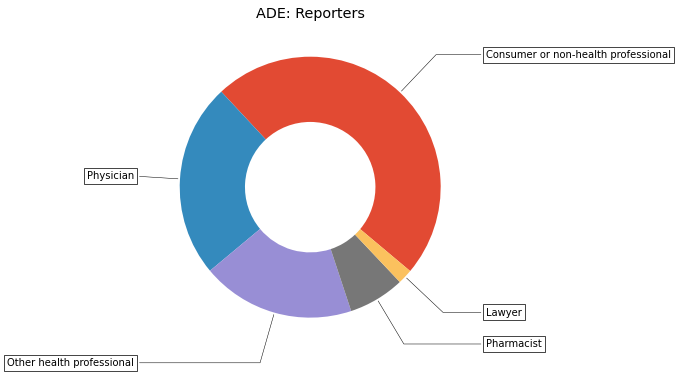

In [74]:
# Plot reference taken from: https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_and_donut_labels.html

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(aspect="equal"))



wedges, texts = ax.pie(res['count'].values, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-",color="black"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(res['term'][i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("ADE: Reporters")

plt.show()

From the above pie-chart, we can see the various persons reporting into the database. 48% are generally reported by consumers or non-health professionals and 24% are reported by physicians. 

For further analysis, we will restrict our data analysis to **physicians** as their entry is expected to be more accuracte compared to others. 

## Country Based Analysis

As many countries can report into the database, we will analyse which countries does the event occur.

In [182]:
search_term='?search=primarysource.qualification:1&count=occurcountry.exact'
res=openFDA_get_request(base_url,search_term, api_key)

Count Query


In [183]:
res=pd.DataFrame(res)
res['Code']=res['term'].str.upper()
country=pd.read_csv("country_csv.txt")#ISO 3166-1-alpha-2 English country names and code elements
country_analysis=pd.merge(res,country, on='Code').drop(columns=['term','Code'])
country_analysis[0:20]#Top 20 country

,count,Name
0,1072331,United States
1,133683,Japan
2,99699,France
3,89043,Germany
4,65006,United Kingdom
5,60894,Italy
6,53926,Canada
7,30443,Spain
8,20597,Australia
9,16059,Brazil


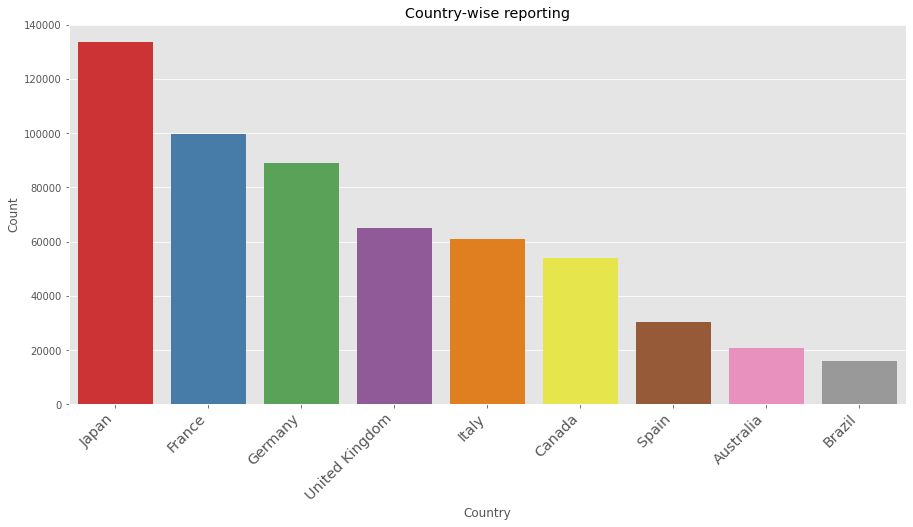

In [192]:
barplot(x="Name",y="count", df=country_analysis[1:10], xlabel="Country", ylabel="Count", title="Country-wise reporting")


From the above chart, other than US, the most countries where the event occurs are in Japan, France, Germany and UK. We will analyse the **top 5 countries other than US** to investigate what they report.

In [177]:
top_5=list(country_analysis['Name'][1:5])
top_5=[x.replace(" ", "+") for x in top_5]
top_5

['Japan', 'France', 'Germany', 'United+Kingdom']

Count Query
Count Query
Count Query
Count Query


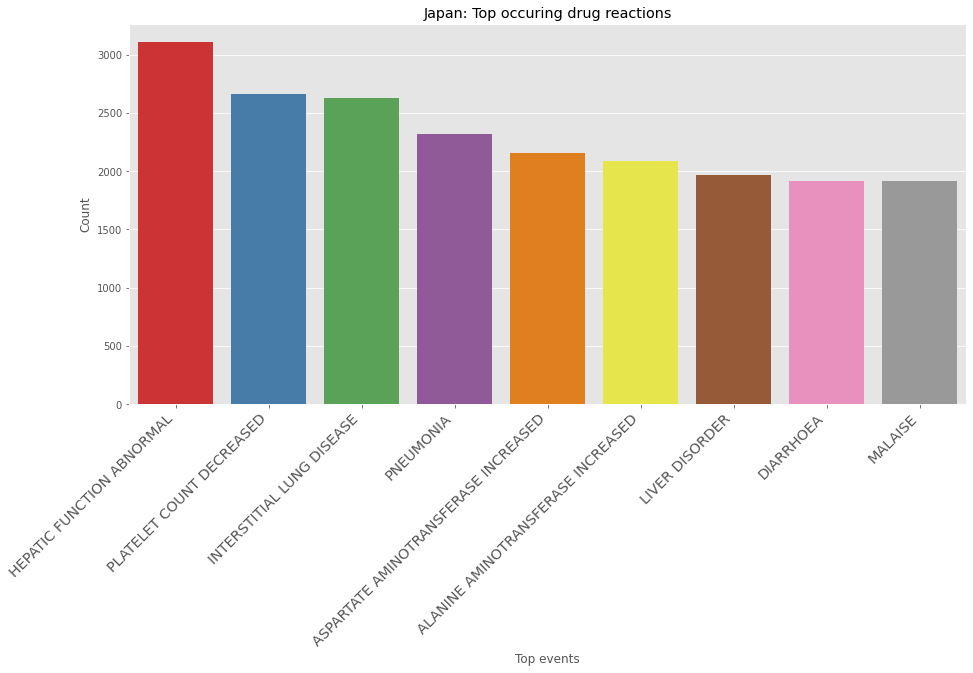

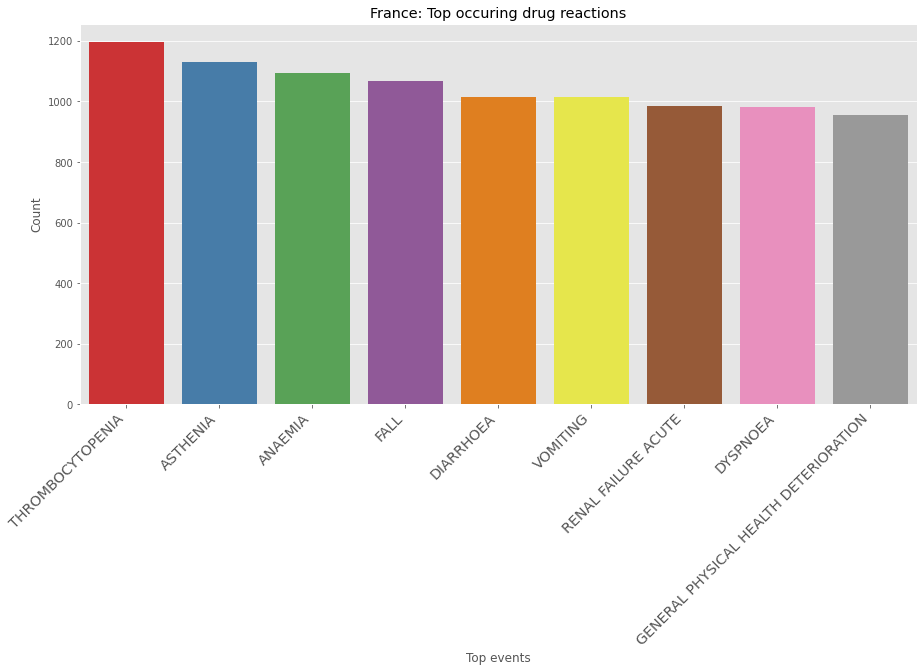

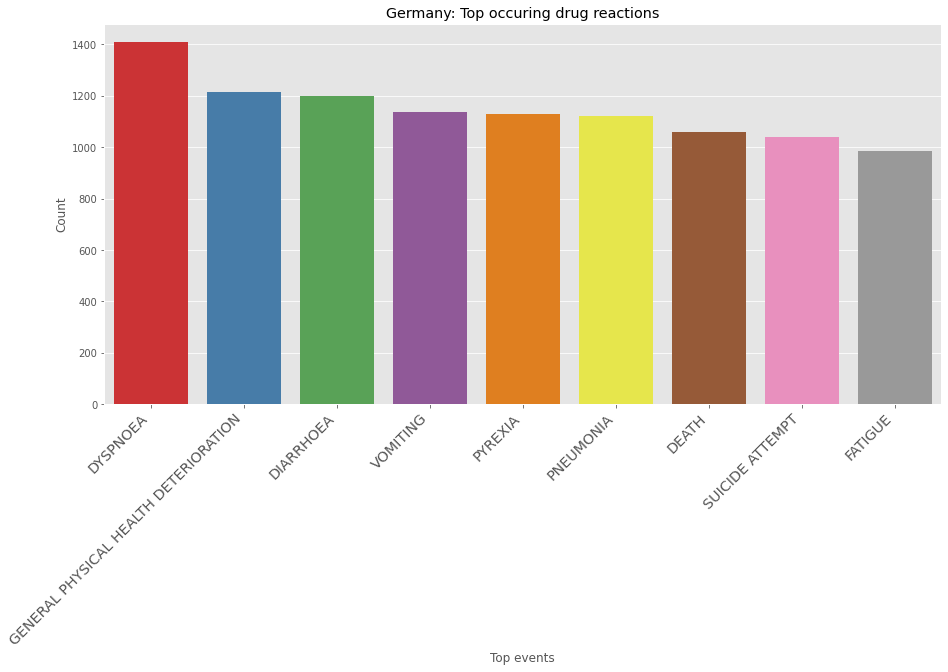

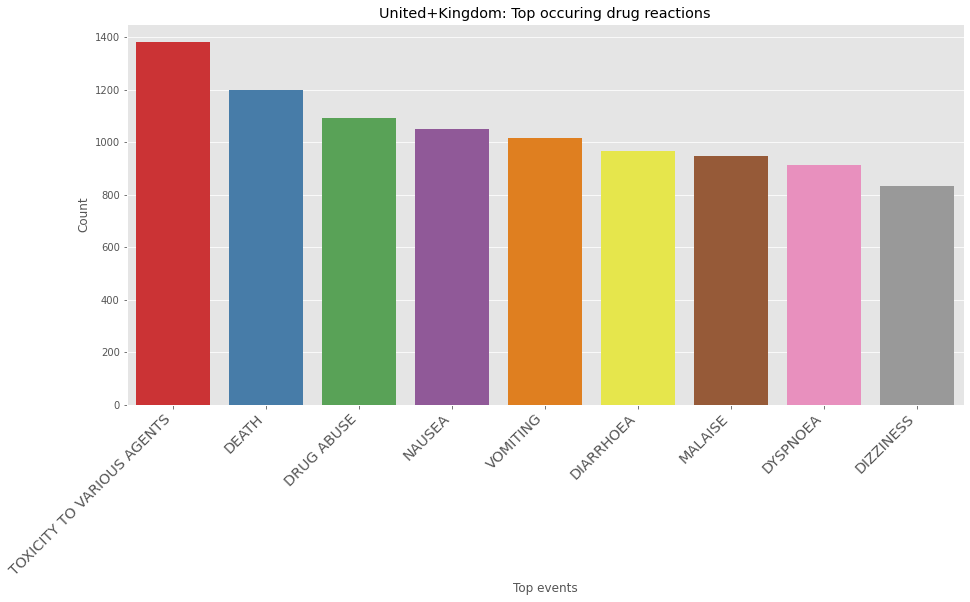

In [193]:
for country in top_5:
    search_term=f'?search=occurcountry.exact={country}+AND+primarysource.qualification:1&count=patient.reaction.reactionmeddrapt.exact'
    res=openFDA_get_request(base_url,search_term, api_key)
    res=pd.DataFrame(res)
    #print(f'Country {country}: Top 10 events reported')
    barplot(x="term",y="count", df=res.iloc[1:10], xlabel="Top events", ylabel="Count", title=f"{country}: Top occuring drug reactions")
   
    

From the above analysis, it seems that there is variations in the reactions that are reported in various countries. Below, we can compare that with the US, where most reported reaction from physicians are "Drug ineffective", whereas in other countries, the reactions are relatively precise. Similarly in the US there is a lot of "off label use". However, not sure these are reactions and perhaps are more related to usage.

Otherwise, it can be seen that most common side-effects include nausea, vomiting, diarrhoea, death etc. Also, looks Germany and United Kingdom follow close to each other in how/what they report.

Count Query


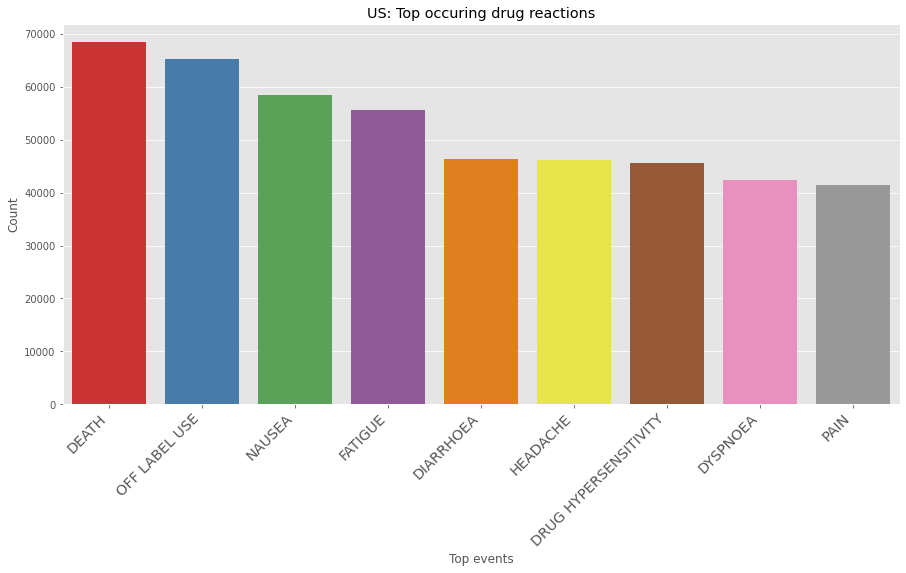

In [194]:
search_term=f'?search=occurcountry.exact="us"+AND+primarysource.qualification:1&count=patient.reaction.reactionmeddrapt.exact'
res=openFDA_get_request(base_url,search_term, api_key)
res=pd.DataFrame(res)
#print(f'Country {country}: Top 10 events reported')
barplot(x="term",y="count", df=res.iloc[1:10], xlabel="Top events", ylabel="Count", title=f"US: Top occuring drug reactions")


**Analyse the top drugs reported in each country**

In this subsection, we will analyse the which drugs gets reported based on the occuring country. One of the challenges was to understand which fields are related to drug names. It seems there are different names and hierarchy for identifying drug names. 

1. Openfda.generic_name
2. patient.drug.medicinalproduct: Trade name of the product (e.g ADVIL) or generic name (e.g IBUPROFEN)
3. patient.drug.openfda.pharm_class_epc: Established pharmacologic class associated with an approved indication of an active moiety (generic drug) 
4. patient.drug.openfda.substance_name:list of active ingredients of a drug product.


For this analysis, we will focus on openfda.generic_name and the openfda.pharm_class_epc (pharmocologic class). 

Count Query
Count Query
Count Query
Count Query


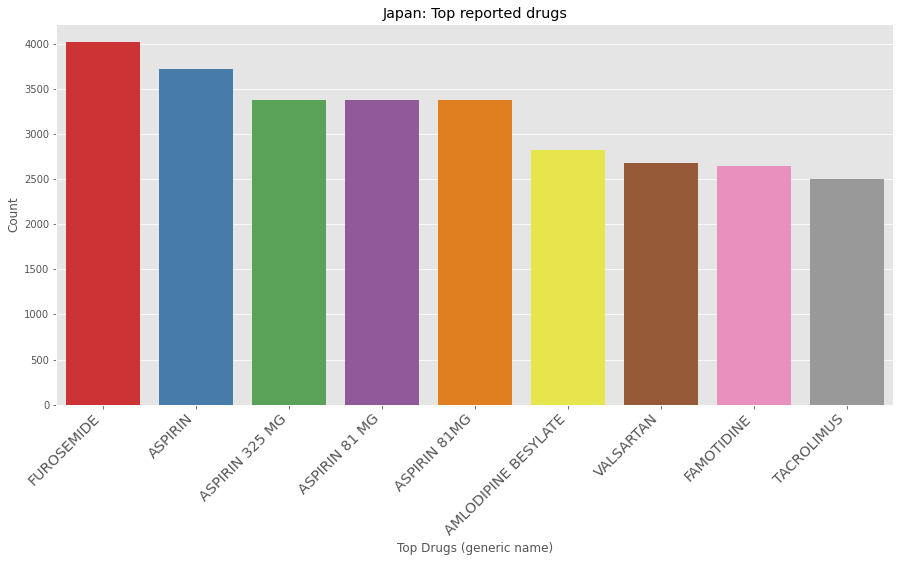

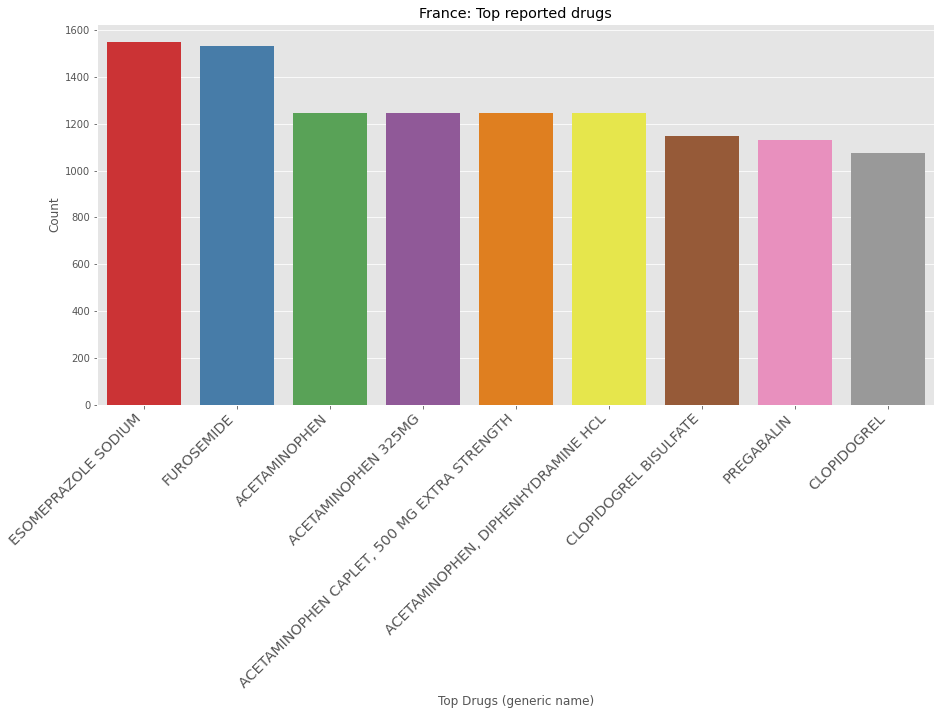

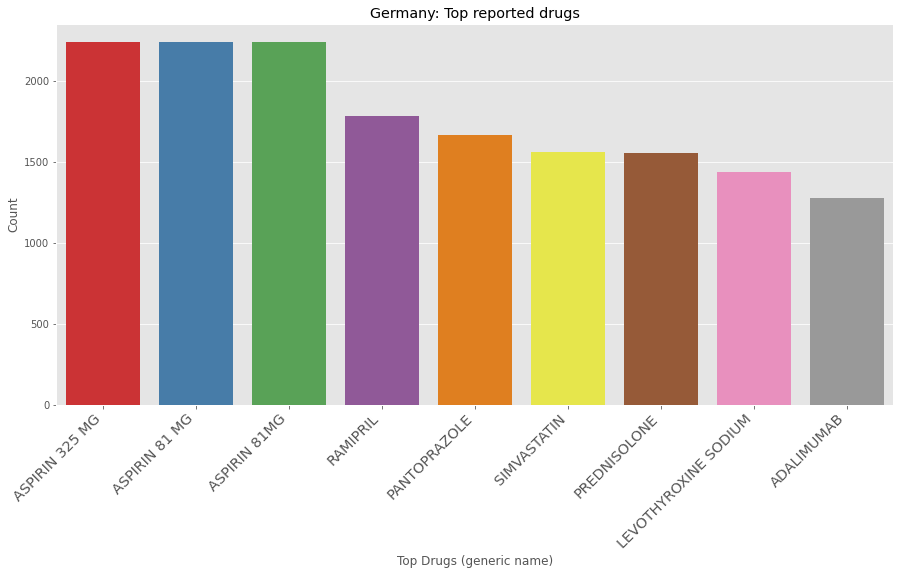

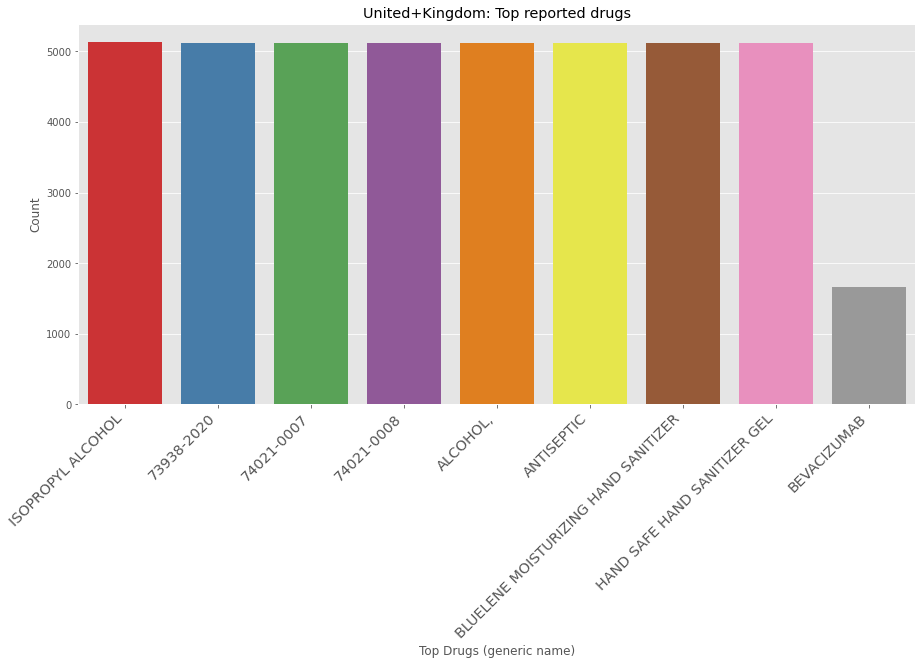

In [195]:
for country in top_5:
    search_term=search_term=f'?search=occurcountry.exact={country}+AND+primarysource.qualification:1&count=patient.drug.openfda.generic_name.exact'
    res=openFDA_get_request(base_url,search_term, api_key)
    res=pd.DataFrame(res)
    #print(f'Country {country}: Top 10 events reported')
    barplot(x="term",y="count", df=res.iloc[1:10], xlabel="Top Drugs (generic name)", ylabel="Count", title=f"{country}: Top reported drugs")

    

Count Query
Count Query
Count Query
Count Query


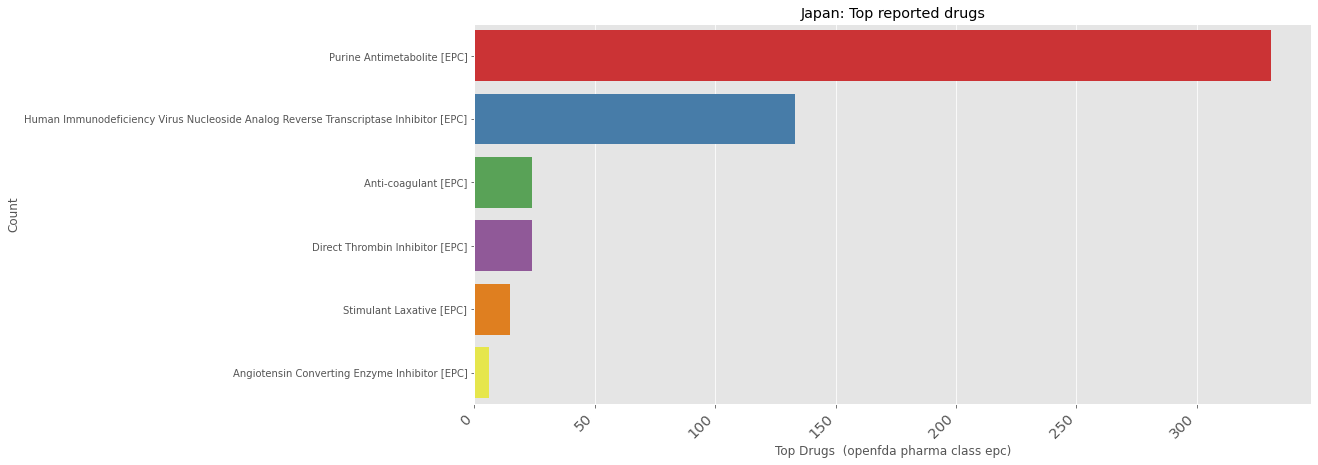

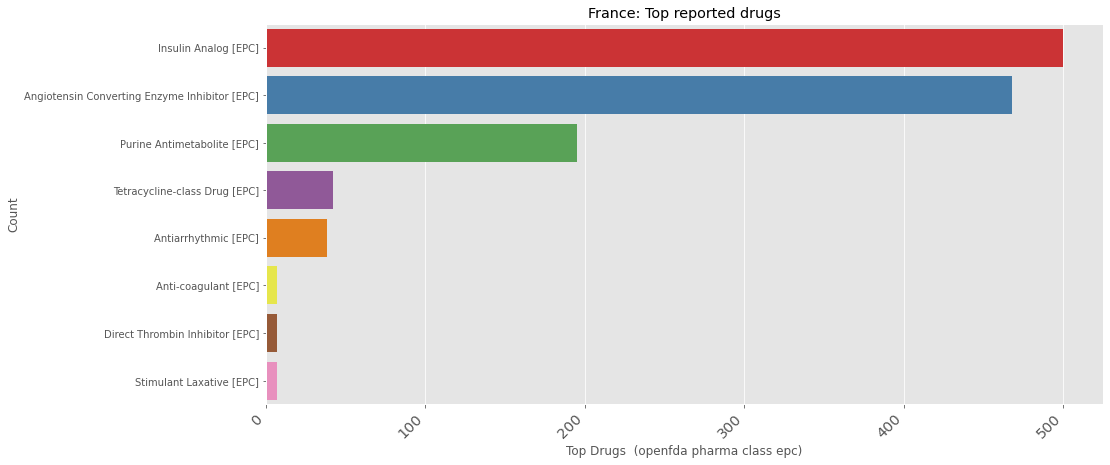

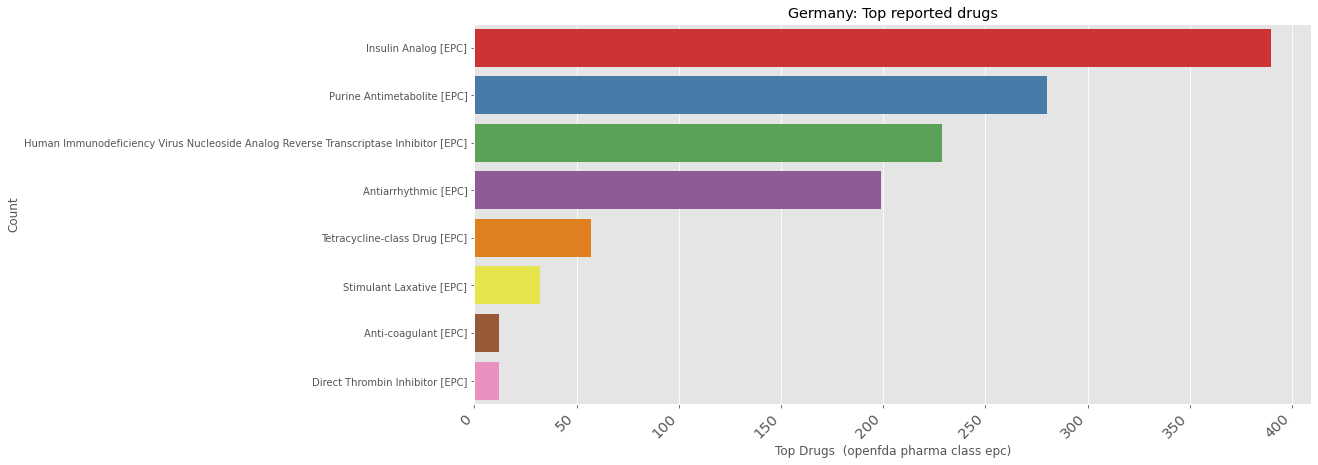

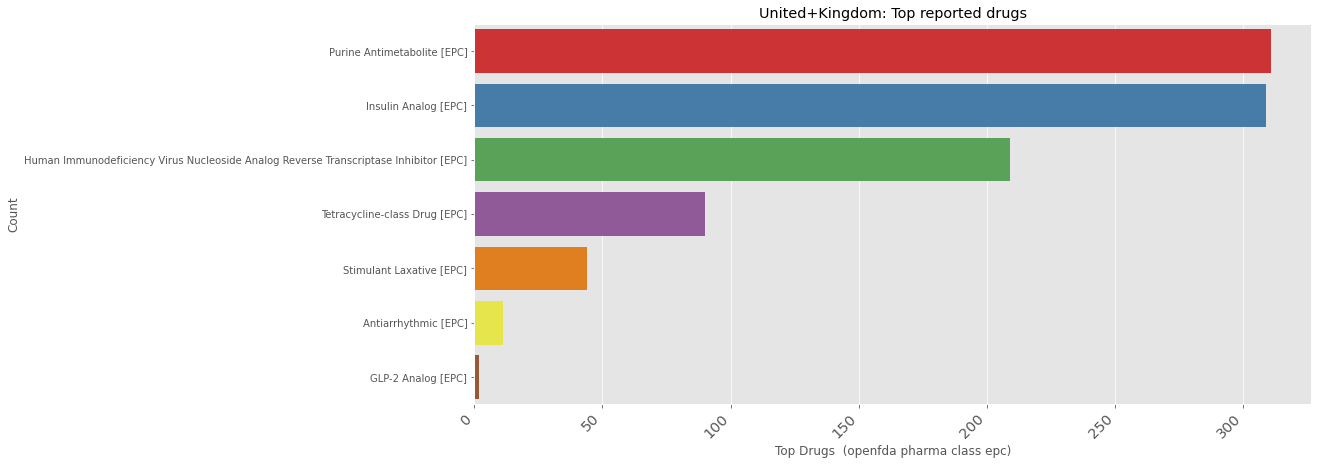

In [196]:
for country in top_5:
    search_term=f'?search=occurcountry.exact={country}+AND+primarysource.qualification:1&count=patient.drug.openfda.pharm_class_epc.exact'
    res=openFDA_get_request(base_url,search_term, api_key)
    res=pd.DataFrame(res)
    #print(f'Country {country}: Top 10 events reported')
    barplot(x="count",y="term", df=res.iloc[1:10], xlabel="Top Drugs  (openfda pharma class epc)", ylabel="Count", title=f"{country}: Top reported drugs")



Count Query
Count Query
Count Query
Count Query


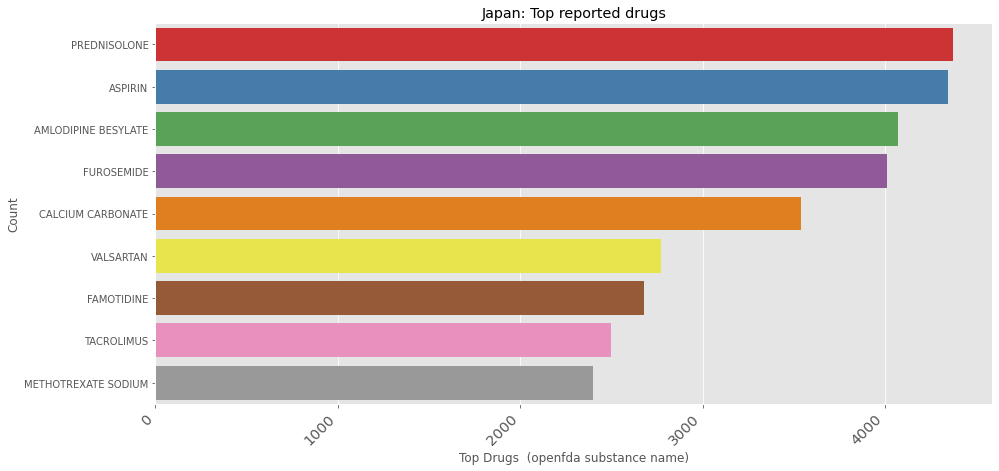

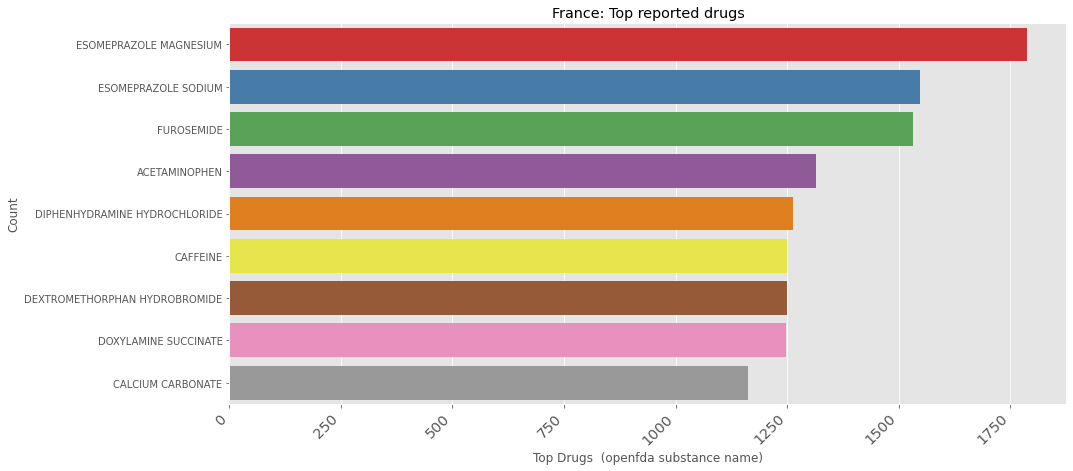

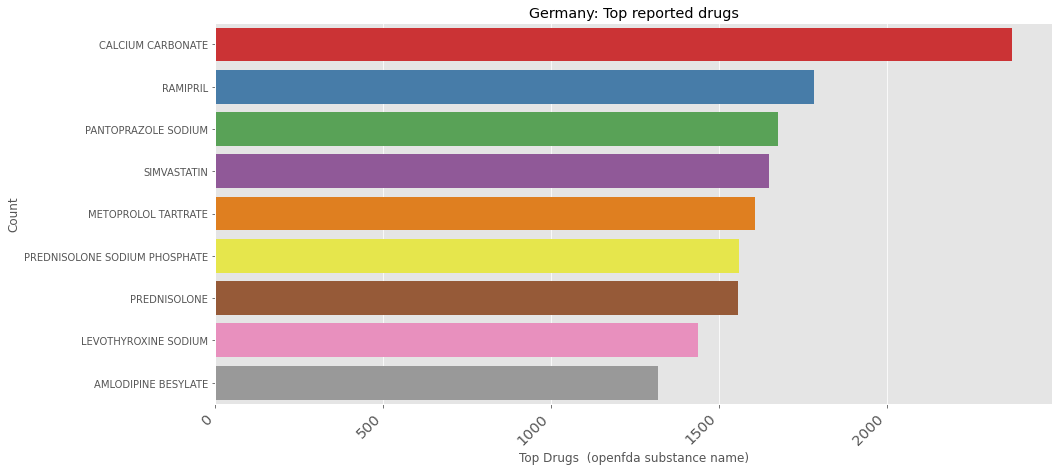

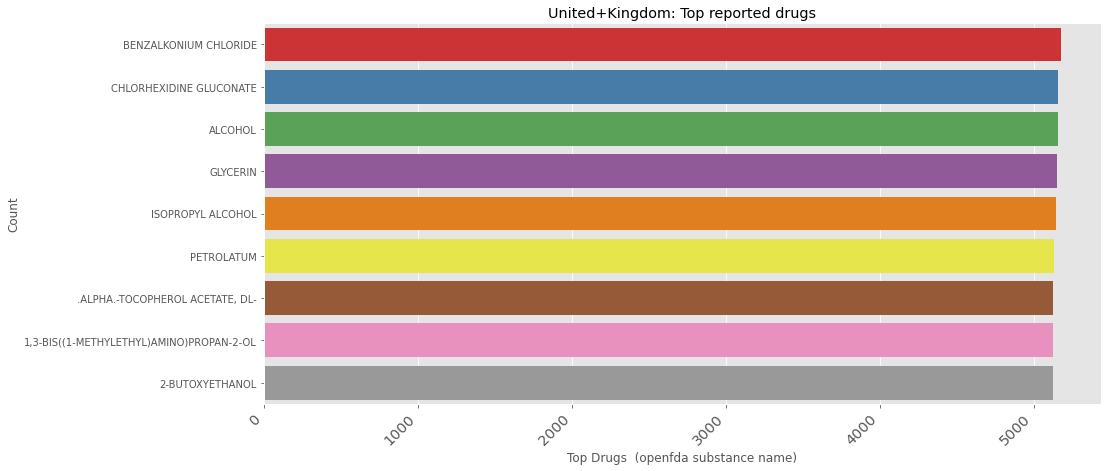

In [198]:
for country in top_5:
    search_term=f'?search=occurcountry.exact={country}+AND+primarysource.qualification:1&count=patient.drug.openfda.substance_name.exact'
    res=openFDA_get_request(base_url,search_term, api_key)
    res=pd.DataFrame(res)
    #print(f'Country {country}: Top 10 events reported')
    barplot(x="count",y="term", df=res.iloc[1:10], xlabel="Top Drugs  (openfda substance name)", ylabel="Count", title=f"{country}: Top reported drugs")


**Analysing the what cases (seriousness) are reported in most countries**

In [181]:
for country in top_5:
    search_term=f'?search=occurcountry.exact={country}+AND+primarysource.qualification:1&count=serious'
    res=openFDA_get_request(base_url,search_term, api_key)
    res=pd.DataFrame(res)
    print(country)
    print(res)
    
    

Count Query
Japan
   term  count
0     1  64674
1     2   1625
Count Query
France
   term  count
0     1  40431
1     2    589
Count Query
Germany
   term  count
0     1  41845
1     2   1494
Count Query
United+Kingdom
   term  count
0     1  33572
1     2    487


As expected most of the serious cases are reported (an event resulting in death, a life threatening condition, hospitalization, disability, congenital anomaly, or other serious condition).

## Drug Characterisation

In each safety report, multiple drugs and reactions are reported. It is not clear, which drug (or combinations of) actually caused a particular reaction. There is a field in the dataset, patient.drug.drugcharacterization, reporting the role of the drug in the event report. However, these are not validated by the FDA and might have quality/accuracy issues.
This field can take one of the following values:
1 = Suspect (the drug was considered by the reporter to be the cause)
2 = Concomitant (the drug was reported as being taken along with the suspect drug)
3 = Interacting (the drug was considered by the reporter to have interacted with the suspect drug)

We can count the most drugs that were reported suspect, concomitant and interacting


In [185]:
search_term=f'?search=patient.drug.drugcharacterization:1+AND+primarysource.qualification:1&count=patient.drug.openfda.generic_name.exact'
res=openFDA_get_request(base_url,search_term, api_key)
res=pd.DataFrame(res)

Count Query


In [186]:
res

,term,count
0,METHOTREXATE SODIUM,96415
1,ASPIRIN,84431
2,METHOTREXATE,81762
3,ASPIRIN 81 MG,81017
4,ASPIRIN 325 MG,81011
...,...,...
95,LAMOTRIGINE,16423
96,BORTEZOMIB,16364
97,SULFAMETHOXAZOLE AND TRIMETHOPRIM,16348
98,RISPERIDONE,16323


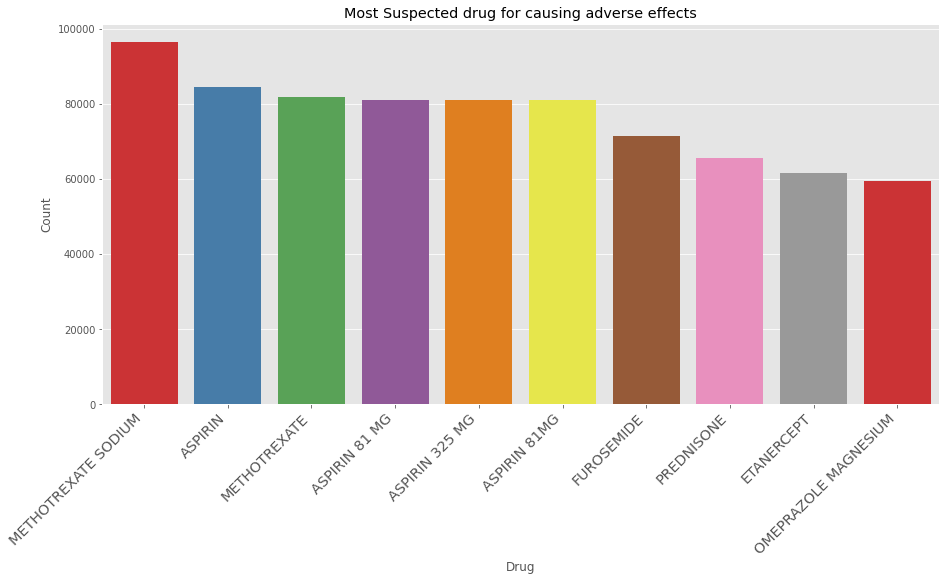

In [190]:
barplot("term", "count", res[0:10], "Drug", "Count", "Most Suspected drug for causing adverse effects")

Count Query


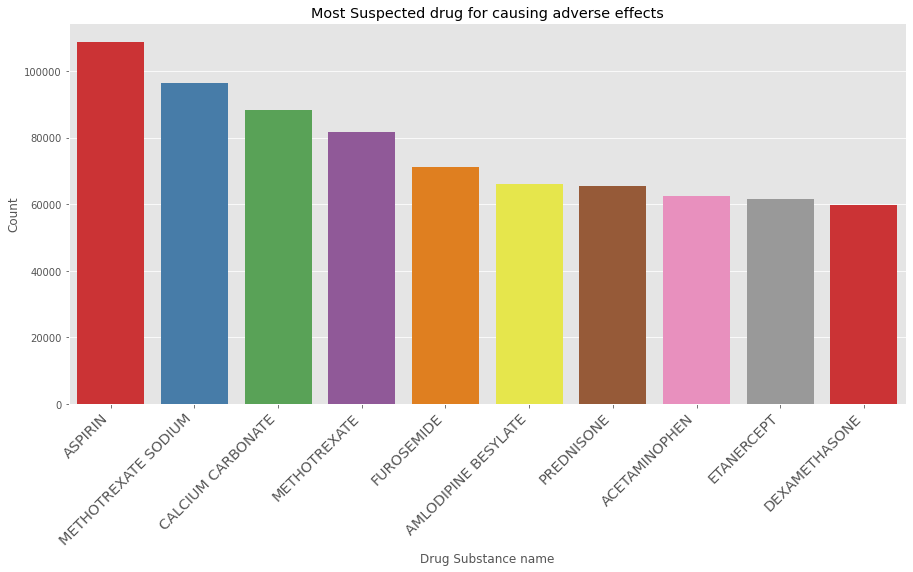

In [199]:
search_term=f'?search=patient.drug.drugcharacterization:1+AND+primarysource.qualification:1&count=patient.drug.openfda.substance_name.exact'
res=openFDA_get_request(base_url,search_term, api_key)
res=pd.DataFrame(res)
barplot("term", "count", res[0:10], "Drug Substance name", "Count", "Most Suspected drug for causing adverse effects")    

## Patient (demographic) Adverse Effects Analysis

The data also consists of various patient data including age, sex and weight. And adverse effect will influence these categories and we can analyse the trends. 

1. Age groups: We will group the ages in three categories 5:20, 20-60, 60-90
2. Weights: Similarly we can categorise as 0:30, 30-70, >70

**Age group against adverse effects**

In this analysis we can investigate the relationship between various age groups and their associated adverse effects

Count Query


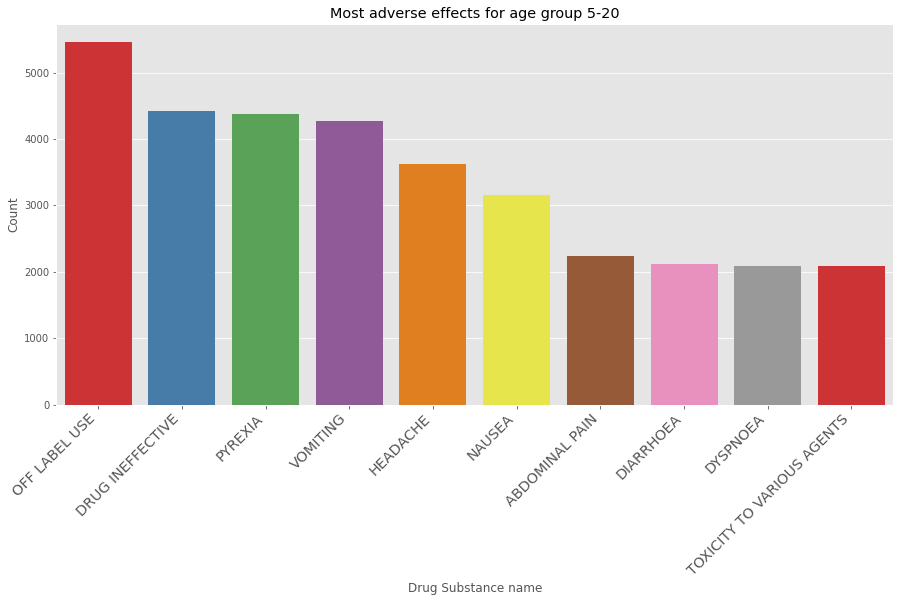

In [204]:
search_term=f'?search=primarysource.qualification:1+AND+patient.patientonsetage:[5+TO+20]&count=patient.reaction.reactionmeddrapt.exact'
res=openFDA_get_request(base_url,search_term, api_key)
res=pd.DataFrame(res)
barplot("term", "count", res[0:10], "Drug Substance name", "Count", "Most adverse effects for age group 5-20") 

Count Query


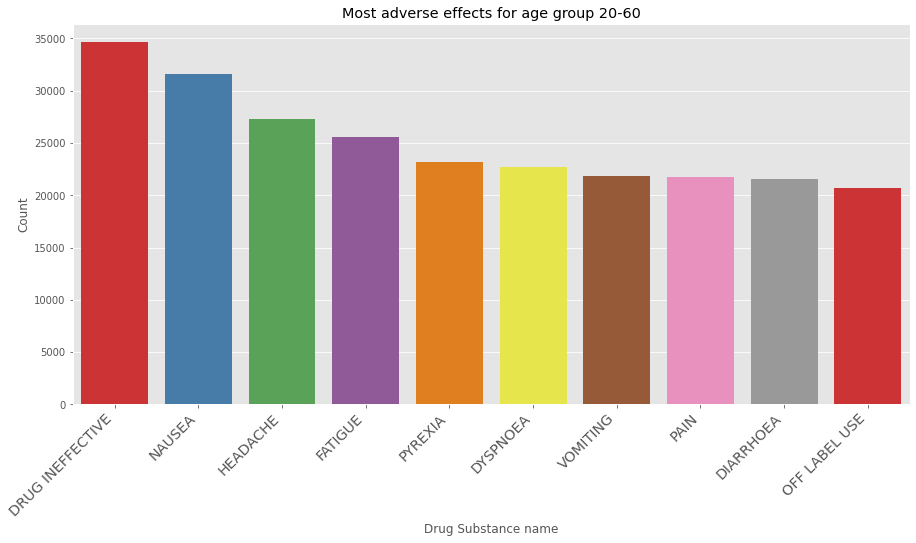

In [206]:
search_term=f'?search=primarysource.qualification:1+AND+patient.patientonsetage:[20+TO+60]&count=patient.reaction.reactionmeddrapt.exact'
res=openFDA_get_request(base_url,search_term, api_key)
res=pd.DataFrame(res)
barplot("term", "count", res[0:10], "Drug Substance name", "Count", "Most adverse effects for age group 20-60")

Count Query


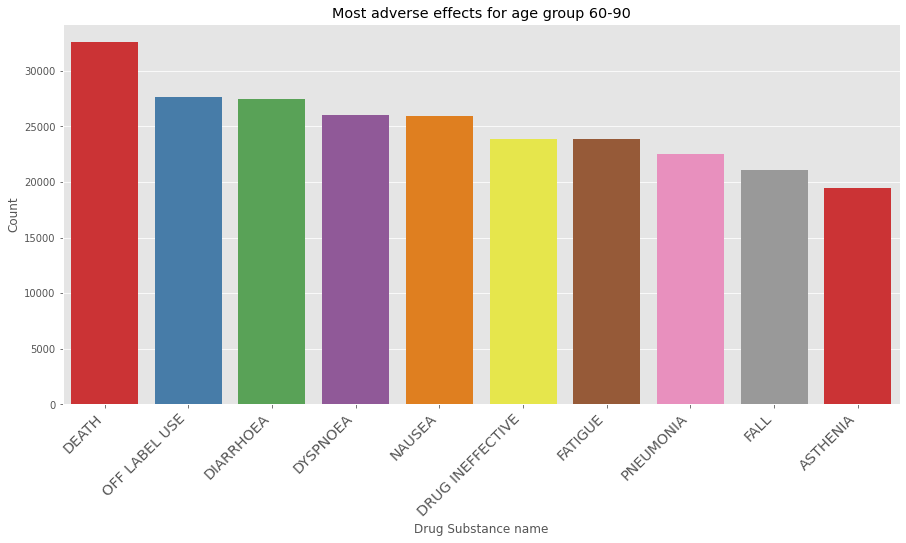

In [241]:
search_term=f'?search=primarysource.qualification:1+AND+patient.patientonsetage:[60+TO+90]&count=patient.reaction.reactionmeddrapt.exact'
res=openFDA_get_request(base_url,search_term, api_key)
res=pd.DataFrame(res)
barplot("term", "count", res[0:10], "Drug Substance name", "Count", "Most adverse effects for age group 60-90")

1. As we can see, there are some difference between different age groups. Increase in age shows death, pneumonia, falling etc, as people's immunity reduces with age. 

2. Younger people generally get adverse effects due to off-label use. Drug ineffective is ambiguous to intrepret. Common side-effects include vomiting, nausea, fatigue and diarrhoea

Note: We only analysed the top 10.
Next we can analyse the difference between male and female groups

Count Query


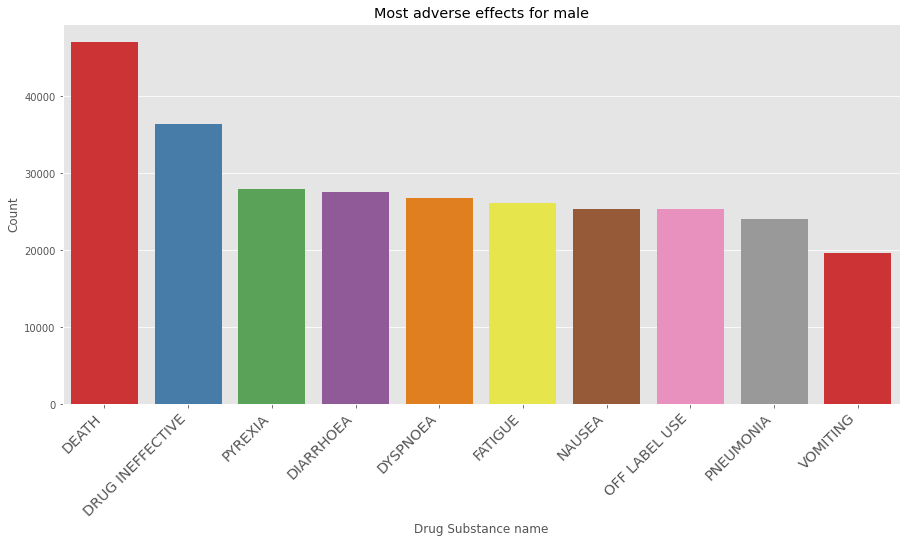

In [242]:
search_term=f'?search=primarysource.qualification:1+AND+patient.patientsex:1&count=patient.reaction.reactionmeddrapt.exact'
res=openFDA_get_request(base_url,search_term, api_key)
res=pd.DataFrame(res)
barplot("term", "count", res[0:10], "Drug Substance name", "Count", "Most adverse effects for male")

Count Query


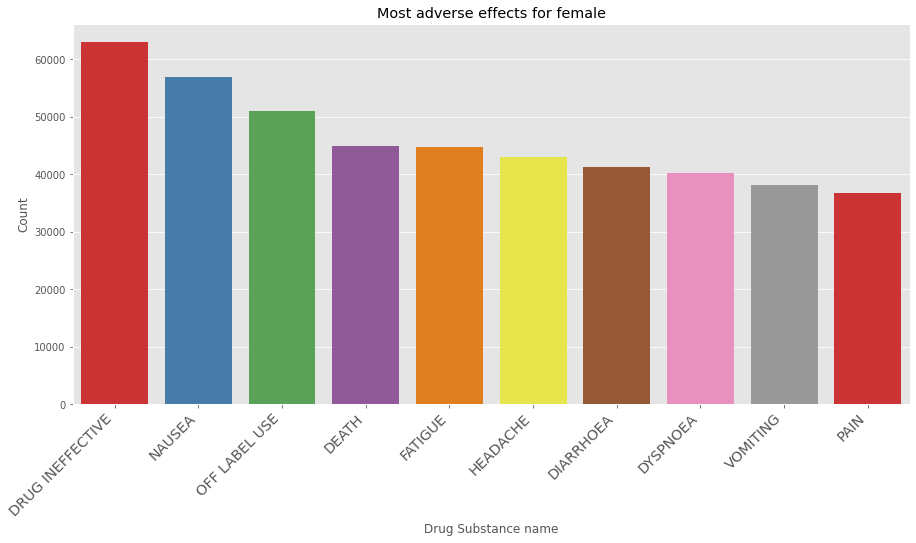

In [243]:
search_term=f'?search=primarysource.qualification:1+AND+patient.patientsex:2&count=patient.reaction.reactionmeddrapt.exact'
res=openFDA_get_request(base_url,search_term, api_key)
res=pd.DataFrame(res)
barplot("term", "count", res[0:10], "Drug Substance name", "Count", "Most adverse effects for female")

There are some differences between male and female. Death is the largest adverse effect report in the database for males, whereas for females, it is "drug ineffective" and nausea. 

We can then analyse if there are any differences between **male and female groups depending on the age category.**

Count Query
Count Query


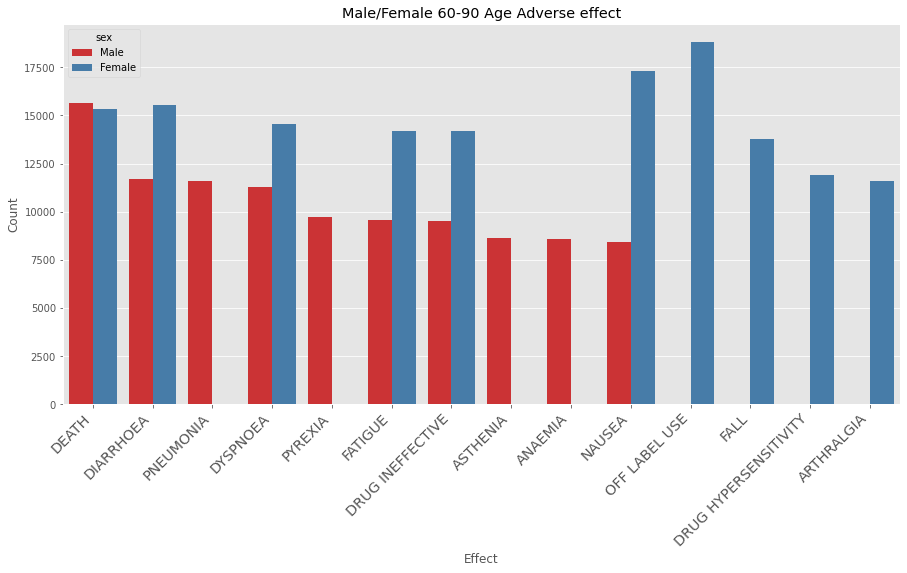

In [236]:
search_term=f'?search=primarysource.qualification:1+AND+patient.patientsex:1+AND+patient.patientonsetage:[60+TO+90]&count=patient.reaction.reactionmeddrapt.exact'
res=openFDA_get_request(base_url,search_term, api_key)
res=pd.DataFrame(res)
res['sex']="Male"
search_term=f'?search=primarysource.qualification:1+AND+patient.patientsex:2+AND+patient.patientonsetage:[60+TO+90]&count=patient.reaction.reactionmeddrapt.exact'
res_temp=openFDA_get_request(base_url,search_term, api_key)
res_temp=pd.DataFrame(res_temp)
res_temp['sex']="Female"
frames=[res[0:10],res_temp[0:10]]
final_df=pd.concat(frames)
final_df
ax = sns.barplot(x="term", y="count", data=final_df,hue="sex",palette='Set1')
ax.set(xlabel="Effect", ylabel="Count")
ax.set(title="Male/Female 60-90 Age Adverse effect")
plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='medium',
        fontsize='x-large'  
);

#barplot("term", "count", res[0:10], "Drug Substance name", "Count", "Most adverse effects for age group 60-90")

Count Query
Count Query


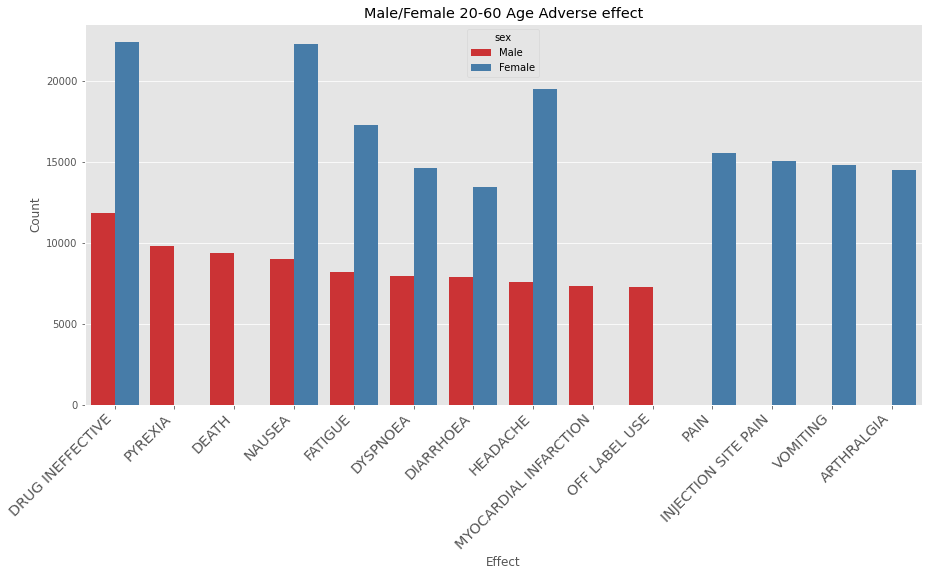

In [239]:
search_term=f'?search=primarysource.qualification:1+AND+patient.patientsex:1+AND+patient.patientonsetage:[20+TO+60]&count=patient.reaction.reactionmeddrapt.exact'
res=openFDA_get_request(base_url,search_term, api_key)
res=pd.DataFrame(res)
res['sex']="Male"
search_term=f'?search=primarysource.qualification:1+AND+patient.patientsex:2+AND+patient.patientonsetage:[20+TO+60]&count=patient.reaction.reactionmeddrapt.exact'
res_temp=openFDA_get_request(base_url,search_term, api_key)
res_temp=pd.DataFrame(res_temp)
res_temp['sex']="Female"
frames=[res[0:10],res_temp[0:10]]
final_df=pd.concat(frames)
final_df
ax = sns.barplot(x="term", y="count", data=final_df,hue="sex",palette='Set1')
ax.set(xlabel="Effect", ylabel="Count")
ax.set(title="Male/Female 20-60 Age Adverse effect")
plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='medium',
        fontsize='x-large'  
);



Count Query
Count Query


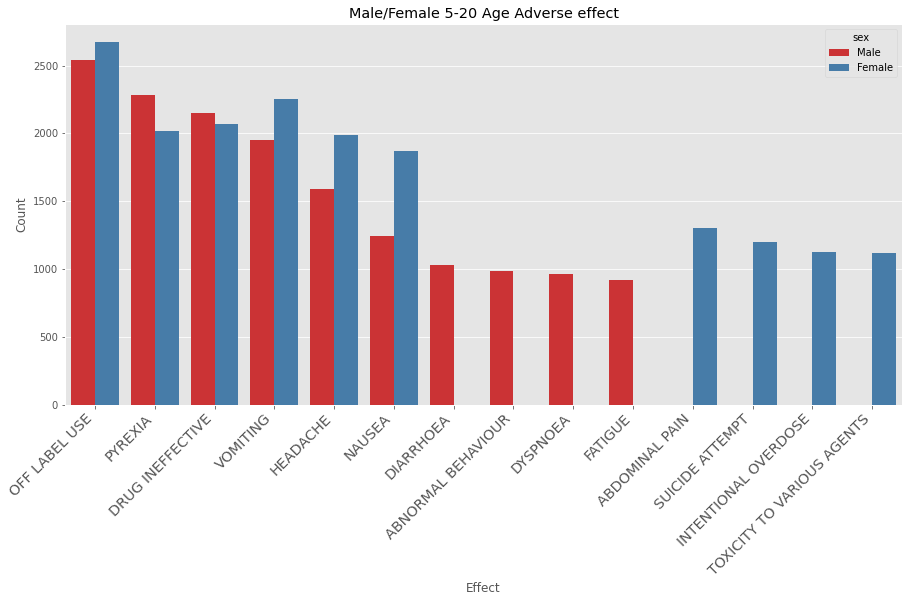

In [240]:
search_term=f'?search=primarysource.qualification:1+AND+patient.patientsex:1+AND+patient.patientonsetage:[5+TO+20]&count=patient.reaction.reactionmeddrapt.exact'
res=openFDA_get_request(base_url,search_term, api_key)
res=pd.DataFrame(res)
res['sex']="Male"
search_term=f'?search=primarysource.qualification:1+AND+patient.patientsex:2+AND+patient.patientonsetage:[5+TO+20]&count=patient.reaction.reactionmeddrapt.exact'
res_temp=openFDA_get_request(base_url,search_term, api_key)
res_temp=pd.DataFrame(res_temp)
res_temp['sex']="Female"
frames=[res[0:10],res_temp[0:10]]
final_df=pd.concat(frames)
final_df
ax = sns.barplot(x="term", y="count", data=final_df,hue="sex",palette='Set1')
ax.set(xlabel="Effect", ylabel="Count")
ax.set(title="Male/Female 5-20 Age Adverse effect")
plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='medium',
        fontsize='x-large'  
);


Similar to the above the analysis, there are some differences in the top 10 adverse effects between males and females for different age group.

1. Age group 5-20: Off label use, vomiting, headache and nausea are the most common for male and female. Additionally, young females have more suicide attempt, overdose etc.

2. Age group 20-60: The number of cases reported in the database for females are much higher than for males. Common side-effects include nausea, vomiting, dyspnoea. 

3. Age group 60-90: Off lable use for females only.
4. Pyrexia and death seem to occur to men than to female.Arthralgia is only common in females

 

## Astrazeneca related reported

There is a manufacturer name in the fields. We can use that to analyse which manufacturer's drug has been most reported.

Count Query


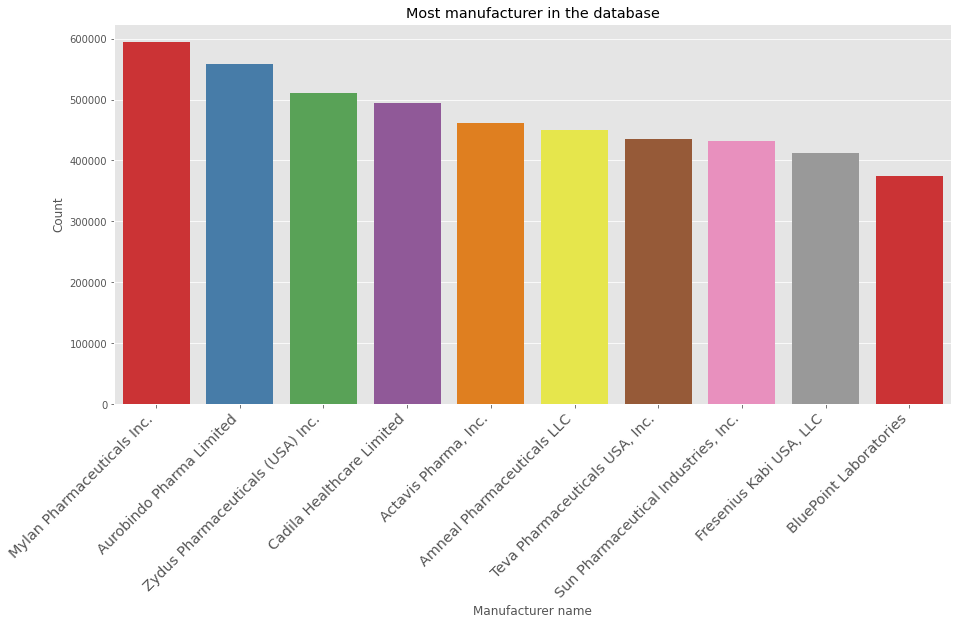

In [246]:
search_term=f'?search=primarysource.qualification:1&count=patient.drug.openfda.manufacturer_name.exact'
res=openFDA_get_request(base_url,search_term, api_key)
res=pd.DataFrame(res)
barplot("term", "count", res[0:10], "Manufacturer name", "Count", "Most manufacturer in the database")

Which drug from AstraZeneca is most reported? What are the most common adverse effects reported for AstraZeneca

In [255]:
search_term=f'?search=primarysource.qualification:1+AND+patient.drug.openfda.manufacturer_name:"astrazeneca"&count=patient.drug.openfda.generic_name.exact'
res=openFDA_get_request(base_url,search_term, api_key)
res=pd.DataFrame(res)
res

Count Query


,term,count
0,QUETIAPINE,29012
1,ROSUVASTATIN CALCIUM,25283
2,ESOMEPRAZOLE MAGNESIUM,24473
3,ESOMEPRAZOLE SODIUM,23240
4,ASPIRIN,14997
...,...,...
95,DIMETHICONE,2277
96,WARFARIN,2270
97,IBUPROFEN TABLETS,2229
98,LEVOTHYROXINE,2209


In [256]:
search_term=f'?search=primarysource.qualification:1+AND+patient.drug.openfda.manufacturer_name:"astrazeneca"&count=patient.drug.openfda.substance_name.exact'
res=openFDA_get_request(base_url,search_term, api_key)
res=pd.DataFrame(res)
res

Count Query


,term,count
0,QUETIAPINE FUMARATE,29012
1,ROSUVASTATIN CALCIUM,25283
2,ESOMEPRAZOLE MAGNESIUM,25031
3,ESOMEPRAZOLE SODIUM,23240
4,ASPIRIN,17510
...,...,...
95,HYDROCODONE BITARTRATE,2164
96,RIVAROXABAN,2140
97,ROSIGLITAZONE MALEATE,2140
98,CETIRIZINE HYDROCHLORIDE,2136


In [258]:
search_term=f'?search=primarysource.qualification:1+AND+patient.drug.openfda.manufacturer_name:"astrazeneca"+AND+patient.drug.openfda.substance_name.exact:"QUETIAPINE FUMARATE"&count=patient.reaction.reactionmeddrapt.exact'
res=openFDA_get_request(base_url,search_term, api_key)
res=pd.DataFrame(res)
res[0:10]

Count Query


,term,count
0,COMPLETED SUICIDE,2302
1,TOXICITY TO VARIOUS AGENTS,1766
2,DRUG INTERACTION,1251
3,DRUG ABUSE,1215
4,SOMNOLENCE,1023
5,OVERDOSE,1005
6,SUICIDE ATTEMPT,997
7,DRUG INEFFECTIVE,948
8,OFF LABEL USE,894
9,DEATH,844


A search for major drugs reported from AstraZeneca shows "Quetiapine fumarate". We can then search for the most common adverse events reported for this drug. The most common adverse event reported for this are suicide, toxicity, drug abuse and somnolence. A quick search reveals that this drug is an antipsychotic medication and is used for the treatement of schizophrenia, bipolar disorder and depression. Therefore, suicide and other related side-effects may not generally be due to the drug itself. 

## Summary and Conclusion

Using openFDA API, we analysed the drug adverse events database. We analysed various aspects:
1. Categories of people reporting into the system.
2. Country-wise analysis: Adverse effects differs for different countries. UK and Germany seem to follow a similar reporting events. Most of the reports from other countries are related to serious effects.
3. Drug Characterisation: Analysed the drugs which are suspected to have caused the side-effects. Aspirin seems to be major cause of the adverse event in various cases.
4. Demographic analysis: Patients age group and sex also has an impact on the adverse effect. 
5. Manufacturer analysis: We also analysed which manufacturer's drug were reported the most. Also analysed one of most reported drug from AstraZeneca, which we found was Quetiapine. 

The openFDA ADE database is vast and contains a lot of information. We showed some of the potential (exploratory) analysis that could be done on the data. Additional work can be carried as:

1. Time series analysis: The report contains a recieved time, which can be used to analyse the adverse effect for a particular drug/disease or drug/adverse event combination and study over time. For instance, we can study whether time has an impact on a particular adverse event. This can be further studied for demographics. As an example, adverse event affects females during summer more than men or men with a certain age group show certain events during winter. These type of analysis will aid in further drug development or carrying out additional clinical tests to validate. 

2. In this notebook, we predominantly focussed on count-style queries to explore the data. Much richer search queries, such as which drugs are taken together for a certain adverse events can be studied. 

3. We could link this data with other FDA datasets, such as substance database. This can be linked by using "unii" codes or substance names. Integrating the publicly available adverse drug event reports data with various chemical and biological data sources in a drug-centric manner to verify the biological plausibility.  Linking them allows us to focus on active ingredients, molecule composition and derive insights into adverse events.

4. We could ideally build a knowledge graph of event/product combinations linking the various molecules/active ingredients. Using this knowledge graph, we can find missing links or find hidden relations, which would aid in quicker/novel drug discovery strategies. There are some new efforts applying machine learning/predictive modelling to predict adverse effects based on compound names, such as  [[1]](#1). 

5. International database: WHO, UK have also their own independent databases. As these event reporting are voluntary and the varying quality of information makes it difficult to draw meaningful conclusions. Analsying across multiple similar databases can, to a certain extent, reduce this. 

In another notebook, we investigate the techniques to monitor safety. In particular we will build a dataset which we can analyse a particular drug and its adverse events. Techinques such as proportional reporting ratio can be uses as a statistical measure.


## References

<a id="1">[1]</a> 
Ietswaart, R., Arat, S., Chen, A.X., Farahmand, S., Kim, B., DuMouchel, W., Armstrong, D., Fekete, A., Sutherland, J.J. and Urban, L., 2020. Machine learning guided association of adverse drug reactions with in vitro target-based pharmacology. bioRxiv, p.750950.

[2] https://open.fda.gov/apis/drug/event/
